In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import pydicom as dicom # for reading dicom files
import os # for doing directory operations 
import pandas as pd # for some simple data analysis 
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pydicom as dicom

import numpy as np
import matplotlib.pyplot as plt
import random
import sys

In [3]:
#importing the layers from keras and all the necessary libraries
import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow import keras

import numpy as np
import pandas as pd

In [4]:
#improving accuracy with another architecture - HybridNET
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

In [5]:
data_dir = "/Users/alifakhry/Downloads/LungCT_Diagnosis-master/NBIA_Files/man/LungCT-Diagnosis/"

In [6]:
!pip install pydicom

In [7]:
# Working Data Directory
# data_dir = '/content/drive/My Drive/CT_Scan/LungCT-Diagnosis/'
patients = os.listdir(data_dir)

labels_df = pd.read_csv('LungCT-Labels - Sheet1.csv', index_col=0)

labels_df.head()

,Labels
Patient Id,
R_004,1
R_006,1
R_013,1
R_014,1
R_019,0


In [8]:
for patient in patients[:10]:
    label = labels_df.at[patient, 'Labels']
    path = data_dir + patient
#slices= no. of scans in each patient folder    

    slices = [dicom.read_file(path + '/' + s, force=True) for s in os.listdir(path)]
    new_slices = []
    for i in slices:
        try:
            y = i.ImagePositionPatient[2]
            new_slices.append(i)
        except:
            pass
    
    new_slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    slices = new_slices

    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(slices[0].pixel_array.shape, len(slices))

(512, 512) 83
(512, 512) 115
(512, 512) 68
(512, 512) 68
(512, 512) 71
(512, 512) 78
(512, 512) 93
(512, 512) 65
(512, 512) 62
(512, 512) 24


In [9]:
len(patients)

61

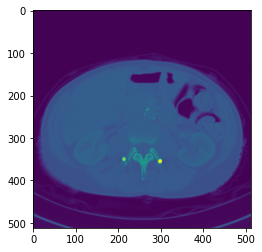

In [10]:
for patient in patients[:1]:
    label = labels_df.at[patient, 'Labels']
    path = data_dir + patient

    slices = [dicom.read_file(path + '/' + s, force=True) for s in os.listdir(path)]
    new_slices = []
    for i in slices:
        try:
            y = i.ImagePositionPatient[2]
            new_slices.append(i)
        except:
            pass
    
    new_slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    slices = new_slices
    
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    # displaying the first slice
    plt.imshow(slices[0].pixel_array)
    plt.show()

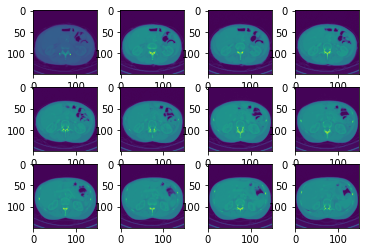

In [11]:

IMG_PX_SIZE = 150

for patient in patients[:1]:
    label = labels_df.at[patient, 'Labels']
    path = data_dir + patient

    slices = [dicom.read_file(path + '/' + s, force=True) for s in os.listdir(path)]
    new_slices = []
    for i in slices:
        try:
            y = i.ImagePositionPatient[2]
            new_slices.append(i)
        except:
            pass
    
    new_slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    slices = new_slices
    
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    fig = plt.figure()
    # displaying the images after resizing
    for num,each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_img)
    plt.show()

In [12]:
# The entire image pre-processing functions


IMG_SIZE_PX = 150
SLICE_COUNT = 20

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]


def mean(a):
    return sum(a) / len(a)


def process_data(patient,labels_df,img_px_size=150, hm_slices=20, visualize=False):
    
    label = labels_df.at[patient, 'Labels']
    path = data_dir + patient
    
    slices = [dicom.read_file(path + '/' + s, force=True) for s in os.listdir(path)]
    new_slices = []
    for i in slices:
        try:
            y = i.ImagePositionPatient[2]
            new_slices.append(i)
        except:
            pass
    
    new_slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    slices = new_slices
    new_slices = []
    
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if len(new_slices) == hm_slices-3:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-4:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1]) 

    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()

    if label == 1: label=np.array([0,1])
    elif label == 0: label=np.array([1,0])
    print(len(slices), len(new_slices))
        
    return np.array(new_slices),label

patients = os.listdir(data_dir)
labels = pd.read_csv('LungCT-Labels - Sheet1.csv', index_col=0)

image_full_data = [] #list of the concatenated 3D images and their corresponding labels 

for num,patient in enumerate(patients):
    if num % 100 == 0:
        print(num)
    try:
        img_data,label = process_data(patient,labels,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
        image_full_data.append([img_data, label])
        # labels_data.append(label)
    except:
        print('Corrupted.')

np.save('imagedata.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), image_full_data)


0
83 20
115 20
68 20
68 20
71 20
78 20
93 20
65 20
62 20
24 12
74 20
65 20
69 20
104 20
88 20
93 20
58 20
130 20
65 20
40 20
63 20
65 20
62 20
74 20
49 20
87 20
76 20
67 20
80 20
108 20
77 20
73 20
34 20
59 20
55 20
63 20
87 20
110 20
86 20
62 20
98 20
70 20
76 20
68 20
74 20
62 20
118 20
65 20
67 20
69 20
79 20
68 20
150 20
Corrupted.
62 20
63 20
112 20
111 20
76 20
69 20
66 20


/Users/alifakhry/anaconda3/envs/mlp/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


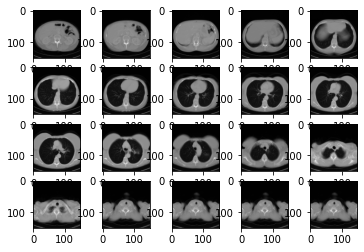

In [13]:
HM_SLICES = 20

for patient in patients[:1]:
    label = labels_df.at[patient, 'Labels']
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s, force=True) for s in os.listdir(path)]
    new_slices = []
    for i in slices:
        try:
            y = i.ImagePositionPatient[2]
            new_slices.append(i)
        except:
            pass
    
    new_slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    slices = new_slices
    new_slices = []

    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    # Making the number of slices uniform for every patient by making chunks
    chunk_sizes = math.ceil(len(slices) / HM_SLICES)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
        
    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val

    if len(new_slices) == HM_SLICES-3:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-4:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])   
      
    #visualizing the slices
    fig = plt.figure()
    for num,each_slice in enumerate(new_slices):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(each_slice, cmap='gray')
    plt.show()

In [14]:
t_y=[]
t_x=[]

v_x=[]
v_y=[]

In [15]:
def set_values(train_X,train_Y,valid_X,valid_Y):
    global t_y
    global t_x
    global v_x
    global v_y
    
    t_y = train_Y[:]
    t_x = train_X[:]
    v_x = valid_X[:]
    v_y = valid_Y[:]

In [16]:
def rec():
    
    try:
        
        print("Attempt:")
    
        image_full_data = np.load('imagedata.npy', allow_pickle=True)
        #shuffling the image full data to remove the clustering of similar type of labels
        random.shuffle(image_full_data)
        # Preparing the train and validation sets
        train_data = image_full_data[:50]
        validation_data = image_full_data[50:]

        train_Y=[]
        valid_Y=[]
        for data in train_data:
            Y = data[1]
            train_Y.append(Y)
        for data in validation_data:
            Y = data[1]
          # print(Y)
            valid_Y.append(Y)

        valid_X = [data[0] for data in validation_data] 
        valid_X = np.concatenate([arr[np.newaxis] for arr in valid_X]) 

        train_X = [data[0] for data in train_data]
        train_X = np.concatenate([arr[np.newaxis] for arr in train_X])  #creating a 4D array from 3 dimensional image arrays

        train_X = np.reshape(train_X, (50,20,150,150,1))
        #train_X = np.expand_dims(train_X, axis = 0)
        train_Y = np.array(train_Y)
        valid_X = np.reshape(valid_X, (10,20,150,150,1))
        valid_Y = np.array(valid_Y)

        print()
        print(train_Y.shape)
        print(valid_Y.shape)
        print(train_X.shape)
        print(valid_X.shape)

        set_values(train_X,train_Y,valid_X,valid_Y)
        
        return
                
    except:
        
        print("Broke!\n")
        
        rec()
        
    
rec()

Attempt:
Broke!

Attempt:
Broke!

Attempt:
Broke!

Attempt:

(50, 2)
(10, 2)
(50, 20, 150, 150, 1)
(10, 20, 150, 150, 1)


In [17]:
#3d sequential cnn architecture 
cnn4 = keras.Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(20,150,150,1)),
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2, 2, 2), padding = 'same', data_format = 'channels_last'),
    Dropout(0.2),
    
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2, 2, 2), padding = 'same', data_format = 'channels_last'),
    Dropout(0.2),
    
    Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'),    
    MaxPooling3D(pool_size=(2, 2, 2), padding = 'same', data_format = 'channels_last'),
    Dropout(0.2),
    
    Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2, 2, 2), padding = 'same', data_format = 'channels_last'),

    Conv3D(512, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    Conv3D(512, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    Conv3D(512, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2, 2, 2), padding = 'same', data_format = 'channels_last'),

    Flatten(),

    Dense(1024, activation='sigmoid'),
    Dropout(0.2),
    Dense(1024, activation='sigmoid'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])
cnn4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 150, 150, 32)  896       
                                                                 
 conv3d_1 (Conv3D)           (None, 20, 150, 150, 32)  27680     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 75, 75, 32)   0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 75, 75, 32)    0         
                                                                 
 conv3d_2 (Conv3D)           (None, 10, 75, 75, 64)    55360     
                                                                 
 conv3d_3 (Conv3D)           (None, 10, 75, 75, 64)    110656    
                                                        

In [18]:
#compiling using stochastic gradient descent
from keras.optimizers import SGD
sgd = SGD(lr=1e-6)
cnn4.compile(loss = 'binary_crossentropy', optimizer =sgd, metrics = ["accuracy"])

/Users/alifakhry/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
#fitting the model
cnn4.fit(t_x, t_y, batch_size=5, epochs=10, verbose=1, validation_data =(v_x,v_y))

Epoch 1/10
10/10 [==============================] - 115s 11s/step - loss: 0.7173 - accuracy: 0.5200 - val_loss: 0.5726 - val_accuracy: 0.8000
Epoch 2/10
10/10 [==============================] - 111s 11s/step - loss: 0.7228 - accuracy: 0.5200 - val_loss: 0.5726 - val_accuracy: 0.8000
Epoch 3/10
10/10 [==============================] - 118s 12s/step - loss: 0.7395 - accuracy: 0.5200 - val_loss: 0.5726 - val_accuracy: 0.8000
Epoch 4/10
10/10 [==============================] - 118s 12s/step - loss: 0.7074 - accuracy: 0.5200 - val_loss: 0.5727 - val_accuracy: 0.8000
Epoch 5/10
10/10 [==============================] - 118s 12s/step - loss: 0.7296 - accuracy: 0.5200 - val_loss: 0.5727 - val_accuracy: 0.8000
Epoch 6/10
10/10 [==============================] - 119s 11s/step - loss: 0.7074 - accuracy: 0.5200 - val_loss: 0.5727 - val_accuracy: 0.8000
Epoch 7/10
10/10 [==============================] - 113s 11s/step - loss: 0.7346 - accuracy: 0.5200 - val_loss: 0.5727 - val_accuracy: 0.8000
Epoch 

In [20]:
train_X = t_x
train_Y = t_y
valid_X = v_x
valid_Y = v_y

In [21]:
cnn4.save("our_model")

INFO:tensorflow:Assets written to: our_model/assets


INFO:tensorflow:Assets written to: our_model/assets


In [22]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [24]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os


init_notebook_mode(connected=True)
%matplotlib inline

In [25]:
input_layer = Input((20, 150, 150, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3) #reshaping the 3D layer to form a Conv2D layer
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=2, activation='softmax')(dense_layer2)

(None, 14, 144, 138, 32)


In [26]:
model = Model(inputs=input_layer, outputs=output_layer)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 150, 150, 1)  0         
                             ]                                   
                                                                 
 conv3d_12 (Conv3D)          (None, 18, 148, 144, 8)   512       
                                                                 
 conv3d_13 (Conv3D)          (None, 16, 146, 140, 16)  5776      
                                                                 
 conv3d_14 (Conv3D)          (None, 14, 144, 138, 32)  13856     
                                                                 
 reshape (Reshape)           (None, 14, 144, 4416)     0         
                                                                 
 conv2d (Conv2D)             (None, 12, 142, 64)       2543680   
                                                             

In [28]:
#compiling the model using adam optimizer
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

/Users/alifakhry/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [29]:
#fitting the model
model.fit(train_X, train_Y, batch_size=5, epochs=5, verbose=1, validation_data =(valid_X,valid_Y))

Epoch 1/5
10/10 [==============================] - 35s 3s/step - loss: 4577.9517 - accuracy: 0.4800 - val_loss: 0.6490 - val_accuracy: 0.3000
Epoch 2/5
10/10 [==============================] - 33s 3s/step - loss: 1.1290 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.2000
Epoch 3/5
10/10 [==============================] - 33s 3s/step - loss: 0.6843 - accuracy: 0.6200 - val_loss: 0.6921 - val_accuracy: 0.7000
Epoch 4/5
10/10 [==============================] - 37s 4s/step - loss: 0.6550 - accuracy: 0.4800 - val_loss: 0.6832 - val_accuracy: 0.8000
Epoch 5/5
10/10 [==============================] - 41s 4s/step - loss: 0.9547 - accuracy: 0.5800 - val_loss: 0.6222 - val_accuracy: 0.8000


In [30]:
model.save("HybridNET")

INFO:tensorflow:Assets written to: HybridNET/assets


INFO:tensorflow:Assets written to: HybridNET/assets
